In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
 
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
import requests
import pandas as pd
from numpy.linalg import norm

import math as math

In [32]:
df = pd.read_csv('data/kaggle_song-features.csv')

In [33]:
df.isnull().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

In [34]:
df['name'].nunique(), df.shape


(133638, (170653, 19))

In [35]:
# Check for duplicated ID and Drop duplicates
df.drop_duplicates(subset = "id", keep = "first", inplace = True)

### Exploratory Data Analysis

In [36]:
df.sample()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
156420,0.0581,1949,0.966,['Andre Kostelanetz & His Orchestra'],0.222,190693,0.221,0,46Vwgc8cI7ZHKAdsN3rSYU,0.947,10,0.212,-17.121,1,Night and Day (From The Gay Divorce),0,1949,0.0425,127.586


In [37]:
# Step 3: Assign emotion labels based on valence and energy
def assign_emotion(row):
    if row['valence'] >= 0.505 and row['energy'] >= 0.505:
        return 'happy'
    elif row['valence'] > 0.495 and row['energy'] < 0.495:
        return 'neutral'
    elif row['valence'] < 0.95 and row['energy'] > 0.495:
        return 'angry'
    else:
        return 'sad'
    
df['emotion'] = df.apply(assign_emotion, axis=1)




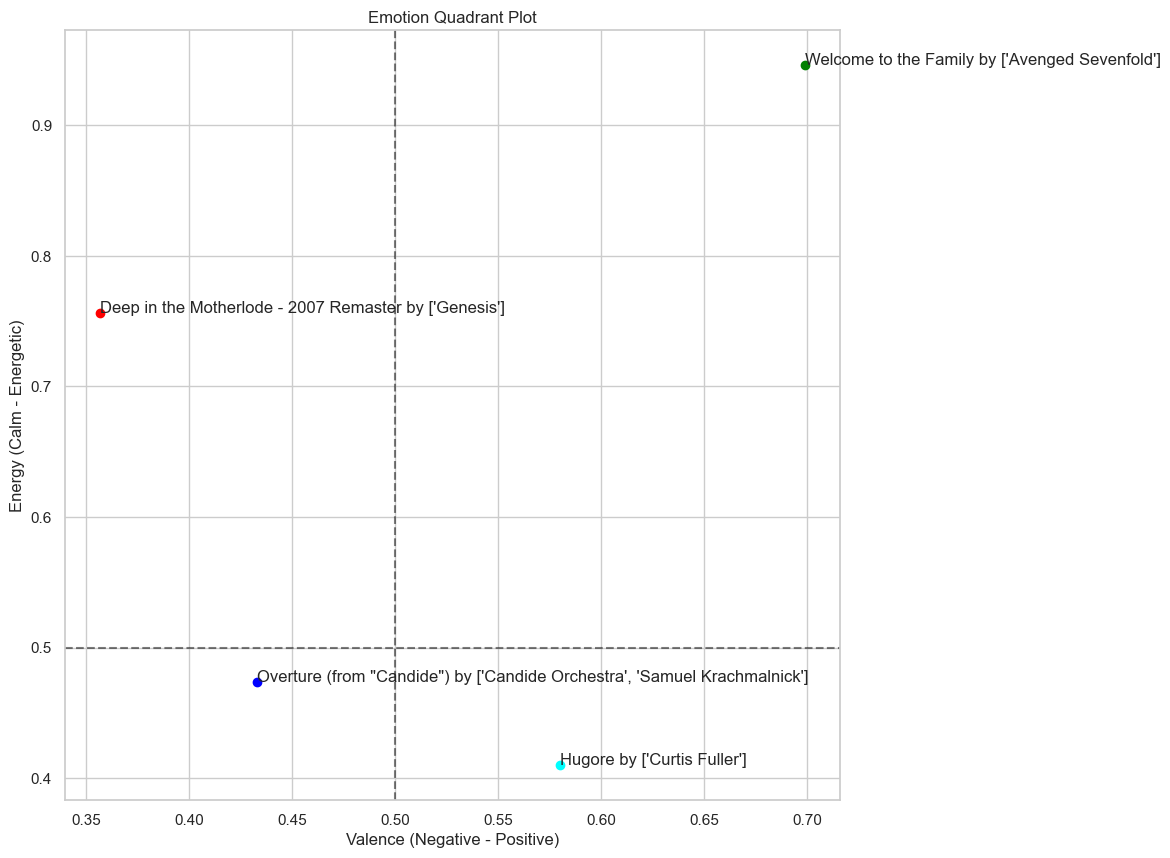

In [38]:
# Step 4: Create a quadrant graph
fig, ax = plt.subplots(figsize=(10, 10))

# Group the dataframe by emotion and take the row with the highest popularity score in each group
top_songs_df = df.groupby('emotion').apply(lambda x: x.sample(n=1))

# Create a scatter plot with different colors for each quadrant
colors = {'happy': 'green', 'neutral': 'cyan',
          'angry': 'red', 'sad': 'blue'}
for i, row in top_songs_df.iterrows():
    ax.scatter(row['valence'], row['energy'], color=colors[i[0]])
    ax.annotate(row['name'] + ' by ' + row['artists'], (row['valence'], row['energy']))
    
# Add labels to the plot
ax.set_xlabel('Valence (Negative - Positive)')
ax.set_ylabel('Energy (Calm - Energetic)')
ax.set_title('Emotion Quadrant Plot')

# Add vertical and horizontal lines at the middle of the graph
ax.axhline(y=0.5, color='black', alpha=0.5, linestyle='--')
ax.axvline(x=0.5, color='black', alpha=0.5, linestyle='--')

# Show the plot
plt.show()


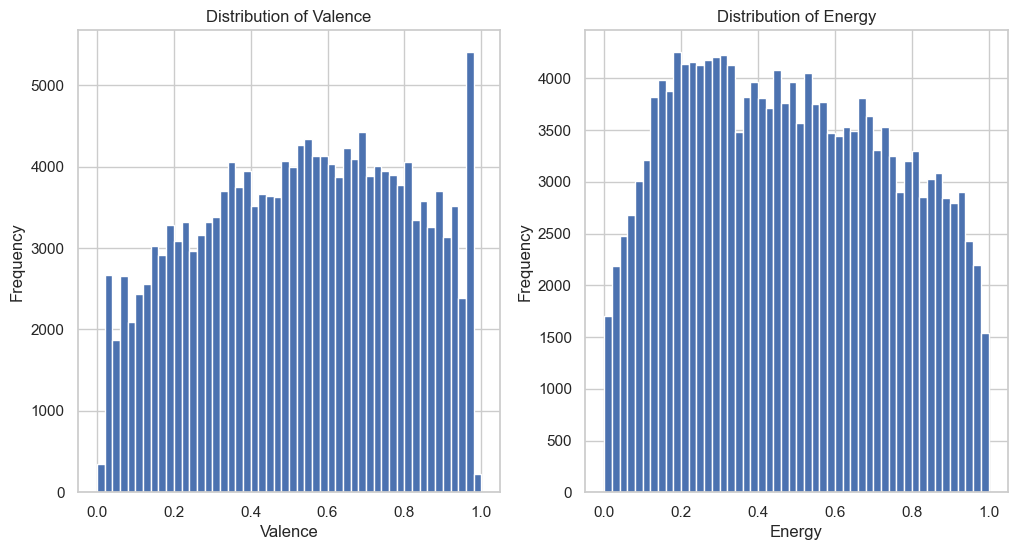

In [39]:
# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram of valence with hist() function
axs[0].hist(df['valence'], edgecolor="white", bins=50)

# Label axes and set title
axs[0].set_title("Distribution of Valence")
axs[0].set_xlabel("Valence")
axs[0].set_ylabel("Frequency")

# Plot the histogram of energy with hist() function
axs[1].hist(df['energy'], edgecolor="white", bins=50)

# Label axes and set title
axs[1].set_title("Distribution of Energy")
axs[1].set_xlabel("Energy")
axs[1].set_ylabel("Frequency")

# Display the plot
plt.show()


### It seems that the two features are normally distributed, approximsting a flat normal distribution. For our data, this means that A 'jump' of 0.2 in valence is similar to a 'jump' of 0.2 in energy. 

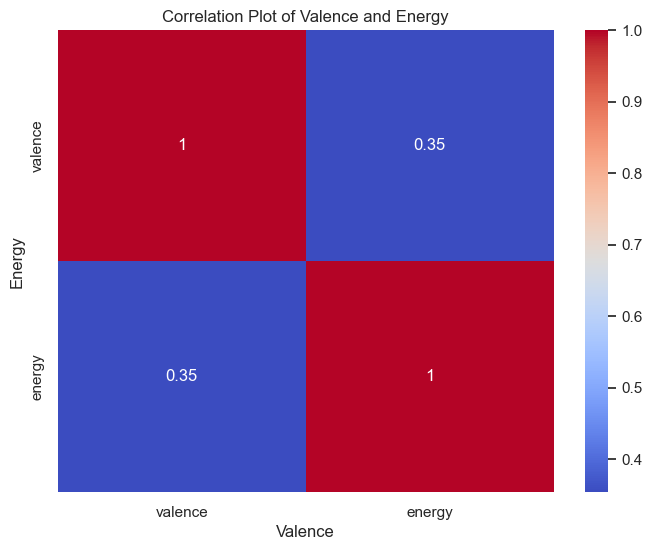

In [40]:
# Create the correlation plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df[['valence', 'energy']].corr(), annot=True, cmap='coolwarm', ax=ax)

# Label axes and set title
ax.set_xlabel('Valence')
ax.set_ylabel('Energy')
ax.set_title('Correlation Plot of Valence and Energy')

plt.show()

In [41]:
df["mood_vec"] = df[["valence", "energy"]].values.tolist()


In [42]:
df.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,emotion,mood_vec
153282,0.182,2008,0.560,['Della'],0.565,233360,0.4550,0,5FGzM47D9MUa0y7qb2D0Ix,0.000000,...,0.1150,-6.632,1,猜不透,57,2008-10-07,0.0346,139.956,sad,"[0.182, 0.455]"
130461,0.176,1968,0.460,['Spirit'],0.276,314933,0.3390,0,7oFxM5vMB3UF698KvUXK70,0.093000,...,0.4250,-14.391,1,Mechanical World,21,1968,0.0343,80.164,sad,"[0.176, 0.339]"
40434,0.801,1936,0.955,['Roy Acuff'],0.556,172827,0.5800,0,0J03JQbjGBSXWfov4Sk9TX,0.165000,...,0.6640,-10.201,1,Weary LoneSome Blues,1,1936,0.0475,146.024,happy,"[0.8009999999999999, 0.58]"
40526,0.349,1936,0.916,['Frente Popular'],0.453,159987,0.0807,0,1Malz2Jnge5sFQkaClXfkk,0.000000,...,0.3600,-12.473,1,Amarrado a la Cadena - Remastered,3,1936-08-15,0.0525,130.970,sad,"[0.349, 0.0807]"
20133,0.889,1927,0.938,"['Jimmie Rodgers', ""Bob Sawyer's Jazz Band""]",0.721,166773,0.6130,0,2SjdHz8MiKvyJTTQyrbpj3,0.000007,...,0.0479,-3.057,1,My Blue Eyed Jane,0,1927,0.0508,128.851,happy,"[0.889, 0.613]"


In [43]:
emotion = 'happy'

In [44]:
df = df[df['emotion'] == emotion]

seed_song = df.sample()
seed_song['valence'], seed_song['energy'], seed_song['id']

(162224    0.597
 Name: valence, dtype: float64,
 162224    0.591
 Name: energy, dtype: float64,
 162224    0pbamYwkr3Msd1GwGbml3p
 Name: id, dtype: object)

In [47]:

import cv2
import streamlit as st
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
import pandas as pd
import time
import os
import statistics
import webbrowser
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Load CSV file containing links for different emotions
df = df[df['emotion'] == 'happy']

seed_song = df.sample()
 
CLIENT_ID = '5237554f6e9545d5bfa9b4d6499acc37'
CLIENT_SECRET = 'e7b63f73c83745cf9ad9f49ebadb70d5'

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Define the seed artist and genre
seed_tracks = seed_song['id']
#Pop,Hip-Hop,Rock,Indie,R&B,Electronic,Dance,Latin,Alternative,Country,Reggaeton
seed_genres = ['rock', 'pop', 'hip-hop','electronic']

# Define the target energy and valence values
target_energy = seed_song['valence']
target_valence = seed_song['energy']

# Call the recommendation API
results = sp.recommendations(seed_tracks=seed_tracks, seed_genres=seed_genres, target_energy=target_energy, target_valence=target_valence)

# Extract the recommended tracks from the response
recommended_tracks = results['tracks']
#print(recommended_tracks)
#print(results['tracks'][0]['album']['artists'][0]['external_urls']['spotify'])

# Print the recommended tracks
for track in recommended_tracks:
    if 'album' in track and 'artists' in track['album'] and 'external_urls' in track and 'spotify' in track['external_urls']:
        track_info = {
            'name': track['name'],
            'artist': track['album']['artists'][0]['name'],
            'album': track['album']['name'],
            'track_link': track['external_urls']['spotify'],
            'artists': track['album']['artists'],
            'available_markets': track['available_markets'],
            'disc_number': track['disc_number'],
            'duration_ms': track['duration_ms'],
            'explicit': track['explicit'],
            'external_ids': track['external_ids'],
            'href': track['href'],
            'id': track['id'],
            'is_local': track['is_local'],
            'popularity': track['popularity'],
            'preview_url': track['preview_url'],
            'track_number': track['track_number'],
            'type': track['type'],
            'uri': track['uri']
        }
        recommended_tracks.append(track_info)
recommended_tracks_df = pd.DataFrame(recommended_tracks)
recommended_tracks_df.dropna(subset=['track_link'],inplace=True)
recommended_tracks_df.track_link.sample()
link = recommended_tracks_df.track_link.sample().values[0]
webbrowser.open_new_tab(link)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
from scipy.stats import shapiro 
shapiro(df.valence).pvalue, shapiro(df.energy).pvalue

(0.0, 0.0)

In [ ]:
# Convert the 'emotion' column to a categorical data type
df_2 = df
df_2['emotion'] = df_2['emotion'].astype('category')

# Create a one-hot encoding of the 'emotion' column
one_hot_df = pd.get_dummies(df_2['emotion'], prefix='emotion')

# Add the one-hot encoded columns to the original DataFrame
df_2 = pd.concat([df, one_hot_df], axis=1)


<Axes: >

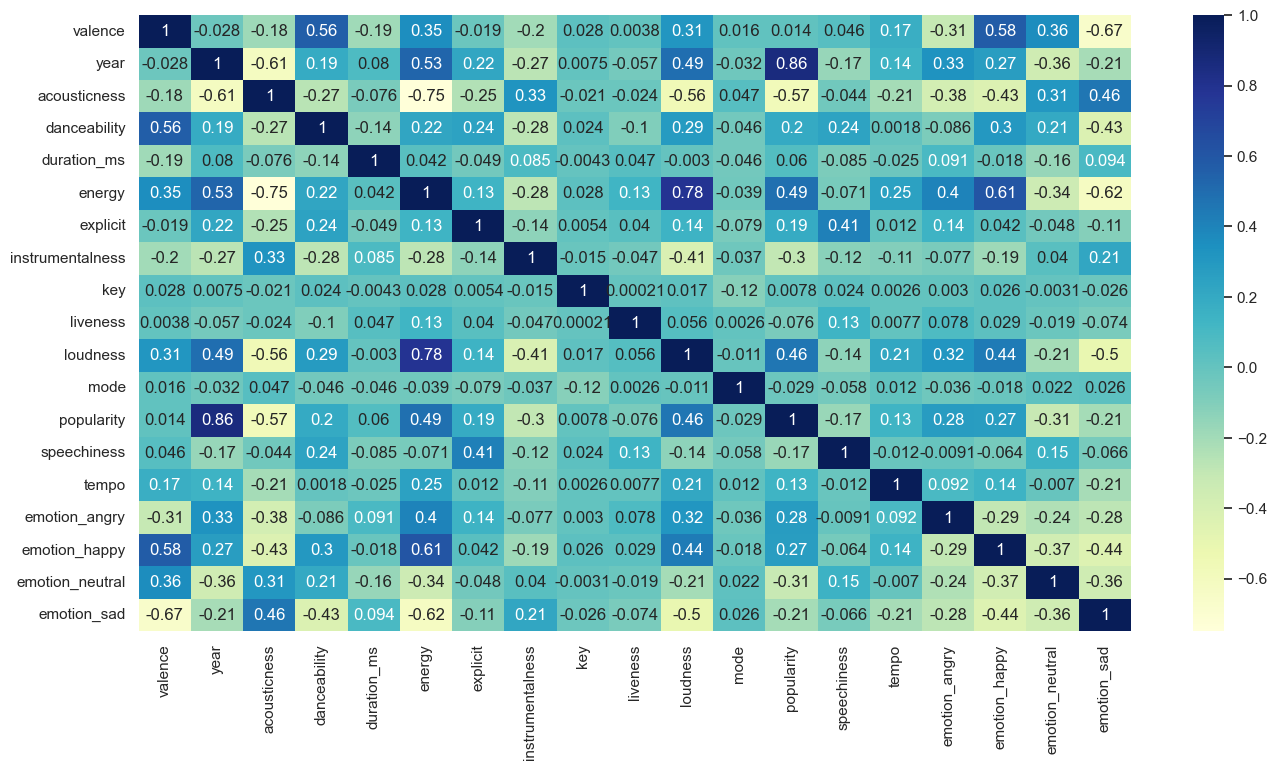

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df_2.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

<Axes: >

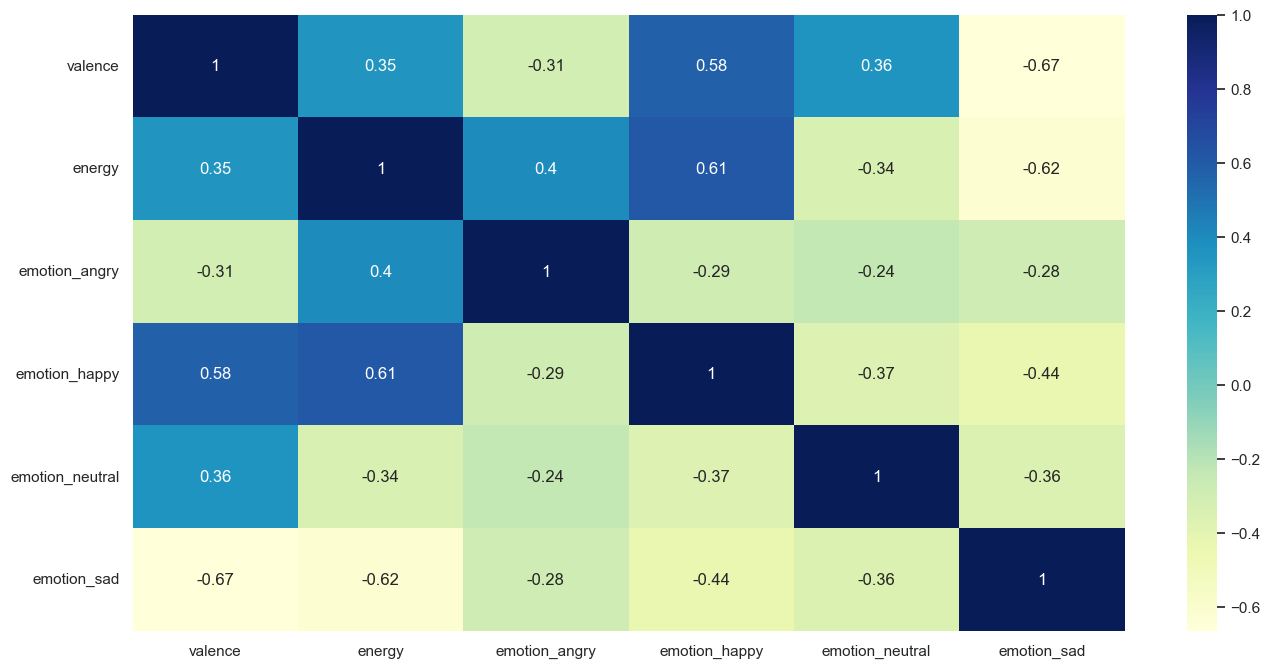

In [ ]:
df_2.drop(['year', 'acousticness', 'danceability',
       'duration_ms', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'popularity', 'release_date',
       'speechiness', 'tempo', 'emotion', 'mood_vec'], axis = 1, inplace = True)
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df_2.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Set up the Spotify API client
client_id = '5237554f6e9545d5bfa9b4d6499acc37'
client_secret = 'e7b63f73c83745cf9ad9f49ebadb70d5'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

track_csv = np.random.choice(df['mood_vec'])
csv_valance = track_csv[0]
csv_energy = track_csv[1]
print(csv_valance, csv_energy)
search_results = sp.search(q='track', type='track', limit=50, market='US')
print(search_results)
similar_songs = []
for track in search_results['tracks']['items']:
    
    track_features = sp.audio_features(track['uri'])[0]
    track_valence = track_features['valence']
    track_energy = track_features['energy']
    print(track_valence, track_energy)
    # Check if the track has similar energy and valence as the input song
    #[0.883, 0.72] - happy 
    #[0.235, 0.402] - sad
    # [0.523, 0.444] - neutral
    #[0.48, 0.6990000000000001] - angry

    if abs(csv_valance - track_valence) < 0.15 and abs(csv_energy - track_energy) < 0.15:
        track_info = sp.track(track['uri'])
        track_link = track_info['external_urls']['spotify']
        similar_songs.append({
            'name': track['name'],
           # 'uri': track['uri'],
            'artist': track['artists'][0]['name'],
            #'album': track['album']['name'],
           # 'release_date': track['album']['release_date'],
           # 'popularity': track['popularity'],
            'track_link': track_link,
            'valence': track_valence,
            'energy': track_energy
        })

# Convert the list of similar songs to a pandas dataframe
similar_songs_df = pd.DataFrame(similar_songs)

# Print the top 10 similar songs
#similar_songs_df.sort_values(by='popularity', ascending=False).head(10)


0.765 0.639
{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track&type=track&market=US&offset=0&limit=50', 'items': [{'album': {'album_group': 'compilation', 'album_type': 'compilation', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of'}, 'href': 'https://api.spotify.com/v1/artists/0LyfQWJT6nXafLPZqxe9Of', 'id': '0LyfQWJT6nXafLPZqxe9Of', 'name': 'Various Artists', 'type': 'artist', 'uri': 'spotify:artist:0LyfQWJT6nXafLPZqxe9Of'}], 'external_urls': {'spotify': 'https://open.spotify.com/album/5rsBQDrPu0hOU559a2wyIs'}, 'href': 'https://api.spotify.com/v1/albums/5rsBQDrPu0hOU559a2wyIs', 'id': '5rsBQDrPu0hOU559a2wyIs', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b27302a23f98ee5f12b3dd3055bb', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e0202a23f98ee5f12b3dd3055bb', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/ab67616d0000485102a23f98ee5f12b3dd3055bb', 'wi

In [ ]:
def select_random_song(df, label):
    # Filter the DataFrame to include only the songs with the given label
    label_df = df[df['label'] == label]
    # Select a random song from the filtered DataFrame
    random_song = label_df.sample(n=1)
    return random_song

# Get a random mood_vec from the dataframe
track_csv = np.random.choice(df['mood_vec'])

# Extract valence and energy from the mood_vec
csv_valance = track_csv[0]
csv_energy = track_csv[1]

# Select a random song with the matching label
random_song = select_random_song(df, f"{csv_valance}_{csv_energy}")

# Print the selected song
print(f"The randomly selected song with label '{csv_valance}_{csv_energy}':")
print(f"{random_song['name']} by {random_song['artists']}")



KeyError: 'label'

In [ ]:
import os 
os.system(f'start {similar_songs_df.track_link.sample()[0]}')

KeyError: 0

In [ ]:
def get_similar_songs(sp, csv_valence, csv_energy):
    # Search for tracks with the given criteria
    search_results = sp.search(q='track', type='track', limit=50, market='US')
    
    # Keep track of the closest and second closest tracks
    closest_track = None
    second_closest_track = None
    closest_distance = 0.15
    second_closest_distance = 0.20
    
    # Iterate over the search results to find the best match
    for track in search_results['tracks']['items']:
        track_features = sp.audio_features(track['uri'])[0]
        track_valence = track_features['valence']
        track_energy = track_features['energy']
        
        # Calculate the distance between the input song and the current track
            #Square Euclidian distance between the two tracks
            #calculate sqrt to convert the disntance back to the original distance scale
            # compare the distance between different pairs of mood_vectors on scale
        distance = math.sqrt((csv_valance - track_valence)**2 + (csv_energy - track_energy)**2)

        # Update the closest and second closest tracks if necessary
        if distance < closest_distance:
            second_closest_track = closest_track
            second_closest_distance = closest_distance
            closest_track = track
            closest_distance = distance
        elif distance < second_closest_distance:
            second_closest_track = track
            second_closest_distance = distance
    
    # Add the best match (or second closest match) to the similar songs list
    similar_songs = []
    if closest_track is not None:
        track_info = sp.track(closest_track['uri'])
        track_link = track_info['external_urls']['spotify']
        similar_songs.append({
            'name': closest_track['name'],
            'artist': closest_track['artists'][0]['name'],
            'track_link': track_link,
            'valence': track_valence,
            'energy': track_energy
        })
    elif second_closest_track is not None:
        track_info = sp.track(second_closest_track['uri'])
        track_link = track_info['external_urls']['spotify']
        similar_songs.append({
            'name': second_closest_track['name'],
            'artist': second_closest_track['artists'][0]['name'],
            'track_link': track_link,
            'valence': track_valence,
            'energy': track_energy
        })
    
    # Return the list of similar songs
    return similar_songs


In [ ]:
track_csv = np.random.choice(df['mood_vec'])
csv_valance = track_csv[0]
csv_energy = track_csv[1]

csv_valance, csv_energy

(0.775, 0.51)

In [ ]:
var = get_similar_songs(sp, csv_valance, csv_energy)
var

[{'name': 'Tracks of My Tears',
  'artist': 'Linda Ronstadt',
  'track_link': 'https://open.spotify.com/track/785Zx8MzinYPVssPaktKoG',
  'valence': 0.835,
  'energy': 0.723}]

In [ ]:
val_dif = abs(csv_valance - var[0]['valence'])
ene_dif = abs(csv_energy - var[0]['energy'])

val_dif, ene_dif

(0.355, 0.09599999999999997)

In [ ]:
var[0]['valence']

0.835

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Set up the Spotify API client
client_id = 'your_client_id_here'
client_secret = 'your_client_secret_here'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Define the target energy and valence values
target_energy = 0.835
target_valence = 0.723
seed_artists='1sXbwvCQLGZnaH0Jp2HTVc'
seed_genres= 'Pop'
seed_tracks='785Zx8MzinYPVssPaktKoG'

# Use the recommendations endpoint to find similar songs
recommendations = sp.recommendations(seed_artists=seed_artists, seed_genres=seed_genres, seed_tracks=seed_tracks, limit=50, country='US', target_energy=target_energy, target_valence=target_valence)

# Convert the list of recommended tracks to a pandas dataframe
recommended_tracks = []
for track in recommendations['tracks']:
    recommended_tracks.append({
        'name': track['name'],
        'artist': track['artists'][0]['name'],
        'track_link': track['external_urls']['spotify'],
        'valence': track['valence'],
        'energy': track['energy']
    })
recommended_tracks_df = pd.DataFrame(recommended_tracks)

# Print the top 10 recommended tracks
print(recommended_tracks_df.head(10))


HTTP Error for GET to https://api.spotify.com/v1/recommendations with Params: {'limit': 50, 'seed_artists': '1,s,X,b,w,v,C,Q,L,G,Z,n,a,H,0,J,p,2,H,T,V,c', 'seed_genres': 'P,o,p', 'seed_tracks': '7,8,5,Z,x,8,M,z,i,n,Y,P,V,s,s,P,a,k,t,K,o,G', 'market': 'US', 'target_energy': 0.835, 'target_valence': 0.723} returned 400 due to invalid request


SpotifyException: http status: 400, code:-1 - https://api.spotify.com/v1/recommendations?limit=50&seed_artists=1%2Cs%2CX%2Cb%2Cw%2Cv%2CC%2CQ%2CL%2CG%2CZ%2Cn%2Ca%2CH%2C0%2CJ%2Cp%2C2%2CH%2CT%2CV%2Cc&seed_genres=P%2Co%2Cp&seed_tracks=7%2C8%2C5%2CZ%2Cx%2C8%2CM%2Cz%2Ci%2Cn%2CY%2CP%2CV%2Cs%2Cs%2CP%2Ca%2Ck%2Ct%2CK%2Co%2CG&market=US&target_energy=0.835&target_valence=0.723:
 invalid request, reason: None

In [ ]:
df


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,emotion,mood_vec
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,sad,"[0.0594, 0.211]"
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,neutral,"[0.963, 0.341]"
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,sad,"[0.0394, 0.166]"
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,sad,"[0.165, 0.309]"
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,sad,"[0.253, 0.193]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,...,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029,happy,"[0.608, 0.8079999999999999]"
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,...,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936,happy,"[0.7340000000000001, 0.753]"
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,...,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688,happy,"[0.637, 0.858]"
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,...,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055,angry,"[0.195, 0.623]"
